# Extract and work with inhibited cells

In [1]:
# Imports:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
import math
import psycopg2
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm_notebook

# Plotting:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set()

# External functions from subfolder /database_helpers. 
# as soon as you change something in there and press save, it will auto reload on next execution.
from database_helpers.psql_start import *
from database_helpers.create_tables import *
from database_helpers.write2tables import *
from postgres_analysis_helpers.general import *
from postgres_analysis_helpers.get_data import *
from postgres_analysis_helpers.circstat_functions import *
# register pickle type to retrieve binary data from database
psycopg2.extensions.register_type(psycopg2.extensions.new_type(psycopg2.BINARY.values, 'BINARY-PICKLE', cast_pickle))

Loaded analysis helpers: General
Loaded postgres_analysis_helpers -> general
Loaded postgres_analysis_helpers -> get_data
Loaded postgres_analysis_helpers -> circstat_functions


In [2]:
# Database connection check
db_status = test_connect()
if db_status == False:
    print('Grrr... no database connection could be established.')
else:
    print('Woot! Database connection is established!')

Connecting to the PostgreSQL database...
Woot! Database connection is established!


### Connect to the database 

In [3]:
stimulus_stats = pd.DataFrame() # create empty dataframe or feed in a base dataframe from before! 
psql = psql_neuroballs(stimulus_stats) # initialize retrieval

78 animals across 5 experimenters found.
Total # of sessions: 8632 (unique clusters: 15361)


**First retrieve all stimulus stats**. That means that only cells for which stimulus sessions were actually run are included in this retrieval step. No baseline sessions are present - only the laser sessions.
This is because the `stimulus_tb` table only contains laser stimulus session information - nothing else! 

In [4]:
dict_ = {'stimulus_tb': ''}
animals_ = ['74470','74471','74933','74935','74472','74473','74956','73358']

stimulus_stats = psql.retrieve_data(dict_,animals_)

8878 entries retrieved.


### Set parameters

In [5]:
# Set parameters:
# excitation:

min_number_sessions = 2 # min number of session for which criteria above have to be fullfilled
p_inhib_thresh = 0.001 # inhibition threshold
inhib_interval_ = 10
# ISI contamination (%)
isi_contam_thresh = 1


### Filter for inhibited cells 

The way to do it is as follows: 
- Filter the stimulus stats for **inhibition lowest p value** < p_inhib_thresh and 
- filter for **most significant inhibition interval** > inhib_interval (should be at 10 = 10ms). This is important to get rid of spurious inhibition due to blanking through the laser
- Filter for **isi contamination**

- *Optional (not included)*: Filter for change point (latency) > 0 ms. However, due to the low number of trials, the inhibition latency cannot always be faithfully extracted - would get rid of some cells unnecessarily  

In [6]:
inhibited_cells = stimulus_stats[(stimulus_stats.inhib_lowest_p < p_inhib_thresh) & (stimulus_stats.inhib_lowest_p_interval > inhib_interval_) & \
                                (stimulus_stats.inhibited == True)].copy()
inhibited_cells.sort_values(by='inhib_lowest_p',ascending=True,inplace=True)

In [7]:
inhibited_cells.head(3)

,cluster_no,tetrode_no,animal_id,session_name,session_ts,n_drive_user,analysis_ts,filename,analysis_window,salt_window,...,ex_latency_var,ex_latency_reliabil,stats_p_inhib_10,stats_p_inhib_20,stats_p_inhib_30,stats_p_inhib_40,inhibited,inhib_lowest_p,inhib_lowest_p_interval,change_point_ms
3338,24,7,74935,22092017laser1(100mW)s1,2017-09-22 18:49:47,horsto,2017-09-23 10:29:39.542,N:/horsto/74935/22092017/KLUSTA/2.kwik,200.0,10.0,...,NaN,NaN,0.000244,2.191527e-08,2.702085e-12,4.201226e-15,True,4.201226e-15,40.0,8.958333
539,52,5,74471,06092017laser2(5mW)s1,2017-09-06 09:55:35,horsto,2017-09-06 14:23:24.317,N:/horsto/74471/06092017/KLUSTA/0.kwik,200.0,10.0,...,NaN,NaN,0.000093,1.033755e-08,6.696499e-12,4.339906e-15,True,4.339906e-15,40.0,3.666667
541,52,5,74471,06092017laser1(5mW)s1,2017-09-06 09:55:35,horsto,2017-09-06 14:23:24.317,N:/horsto/74471/06092017/KLUSTA/0.kwik,200.0,10.0,...,NaN,NaN,0.001107,1.345397e-07,2.064367e-11,1.161008e-14,True,1.161008e-14,40.0,0.229167


### Count sessions and filter for session number

In [8]:
# Group by and count - and also drop duplicates with sort
drop_subgroup = ['animal_id','n_drive_user','session_ts','cluster_no','tetrode_no']
no_sessions_inhibited = inhibited_cells.groupby(drop_subgroup).size().reset_index().copy()
inhibited_cells_sessions = inhibited_cells.drop_duplicates(drop_subgroup).sort_values(by=drop_subgroup).reset_index().copy()

# Quick sanity check (both have to be true)
if ((no_sessions_inhibited.animal_id.values == inhibited_cells_sessions.animal_id.values).all() != True) or ((no_sessions_inhibited.cluster_no.values == inhibited_cells_sessions.cluster_no.values).all() != True): 
    print('DATAFRAMES DO NOT MATCH!'); sys.exit()

In [9]:
inhibited_cells_sessions['no_sessions'] = no_sessions_inhibited.iloc[:,-1].values
len_before_no_session = len(inhibited_cells_sessions)
#overwrite original df
inhibited_cells = inhibited_cells_sessions[inhibited_cells_sessions.no_sessions >= min_number_sessions]

### Get the stimulus_mat table data for later 

In [10]:
psql = psql_neuroballs(inhibited_cells) # initialize retrieval
dict_ = {'stimulus_mat_tb': ''}
inhibited_cells = psql.retrieve_data(dict_)

Length of input dataframe: 250
Dataframe not empty


HBox(children=(IntProgress(value=0, description='Mining tables: ', max=1), HTML(value='')))

Table dictionary is empty for this entry. Taking all columns!
Included the following columns: ('analysis_ts', 'filename', 'sample_rate', 'sample_rate_inp', 'analysis_window', 'counter_stimuli', 'spiketimes_cluster', 'stimulus_timepoints', 'sum_1ms', 'bin_edges_1ms', 'binnumber_1ms')
Column analysis_ts already exists. Skipping.
Column filename already exists. Skipping.
Column sample_rate already exists. Skipping.
Column sample_rate_inp already exists. Skipping.
Column analysis_window already exists. Skipping.
Column counter_stimuli already exists. Skipping.


HBox(children=(IntProgress(value=0, description='stimulus_mat_tb: ', max=250), HTML(value='')))

Success. NaNs: 0



### Now drop the session_name column (to get rid of the laser session label) and retrieve waveforms again, but with a filter for non-laser sessions. Also include ISI contaminations in same go and filter for ISI contamination.

In [11]:
inhibited_cells.drop(['session_name','index'], axis=1,inplace=True)

In [12]:
psql = psql_neuroballs(inhibited_cells) # initialize retrieval
dict_ = {'ISI_tb':'ISI_stats_contam_perc'}
inhibited_cells = psql.retrieve_data(user_sql_tables=dict_,user_sql_filter="NOT LIKE '%las%'")
# filter out ISI contaminations: 
len_before_isi_filt = len(inhibited_cells)

inhibited_cells = inhibited_cells[inhibited_cells.isi_stats_contam_perc < isi_contam_thresh].copy()

Length of input dataframe: 250
Dataframe not empty


HBox(children=(IntProgress(value=0, description='Mining tables: ', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ISI_tb: ', max=250), HTML(value='')))

Success. NaNs: 0



In [13]:
# Sort again - why not ... 
inhibited_cells.sort_values(by='inhib_lowest_p',ascending=True,inplace=True)

### Little summary of where how many cells were lost 

In [14]:
# Summary:
print('Number of cells before ...')
print('No. of session filter: {}'.format(len_before_no_session))
print('ISI filter: {}'.format(len_before_isi_filt))
print('Remaining: {}'.format(len(inhibited_cells)))

Number of cells before ...
No. of session filter: 434
ISI filter: 261
Remaining: 246


### Draw some stuff

HBox(children=(IntProgress(value=0, max=15), HTML(value='')))


Generating plot...


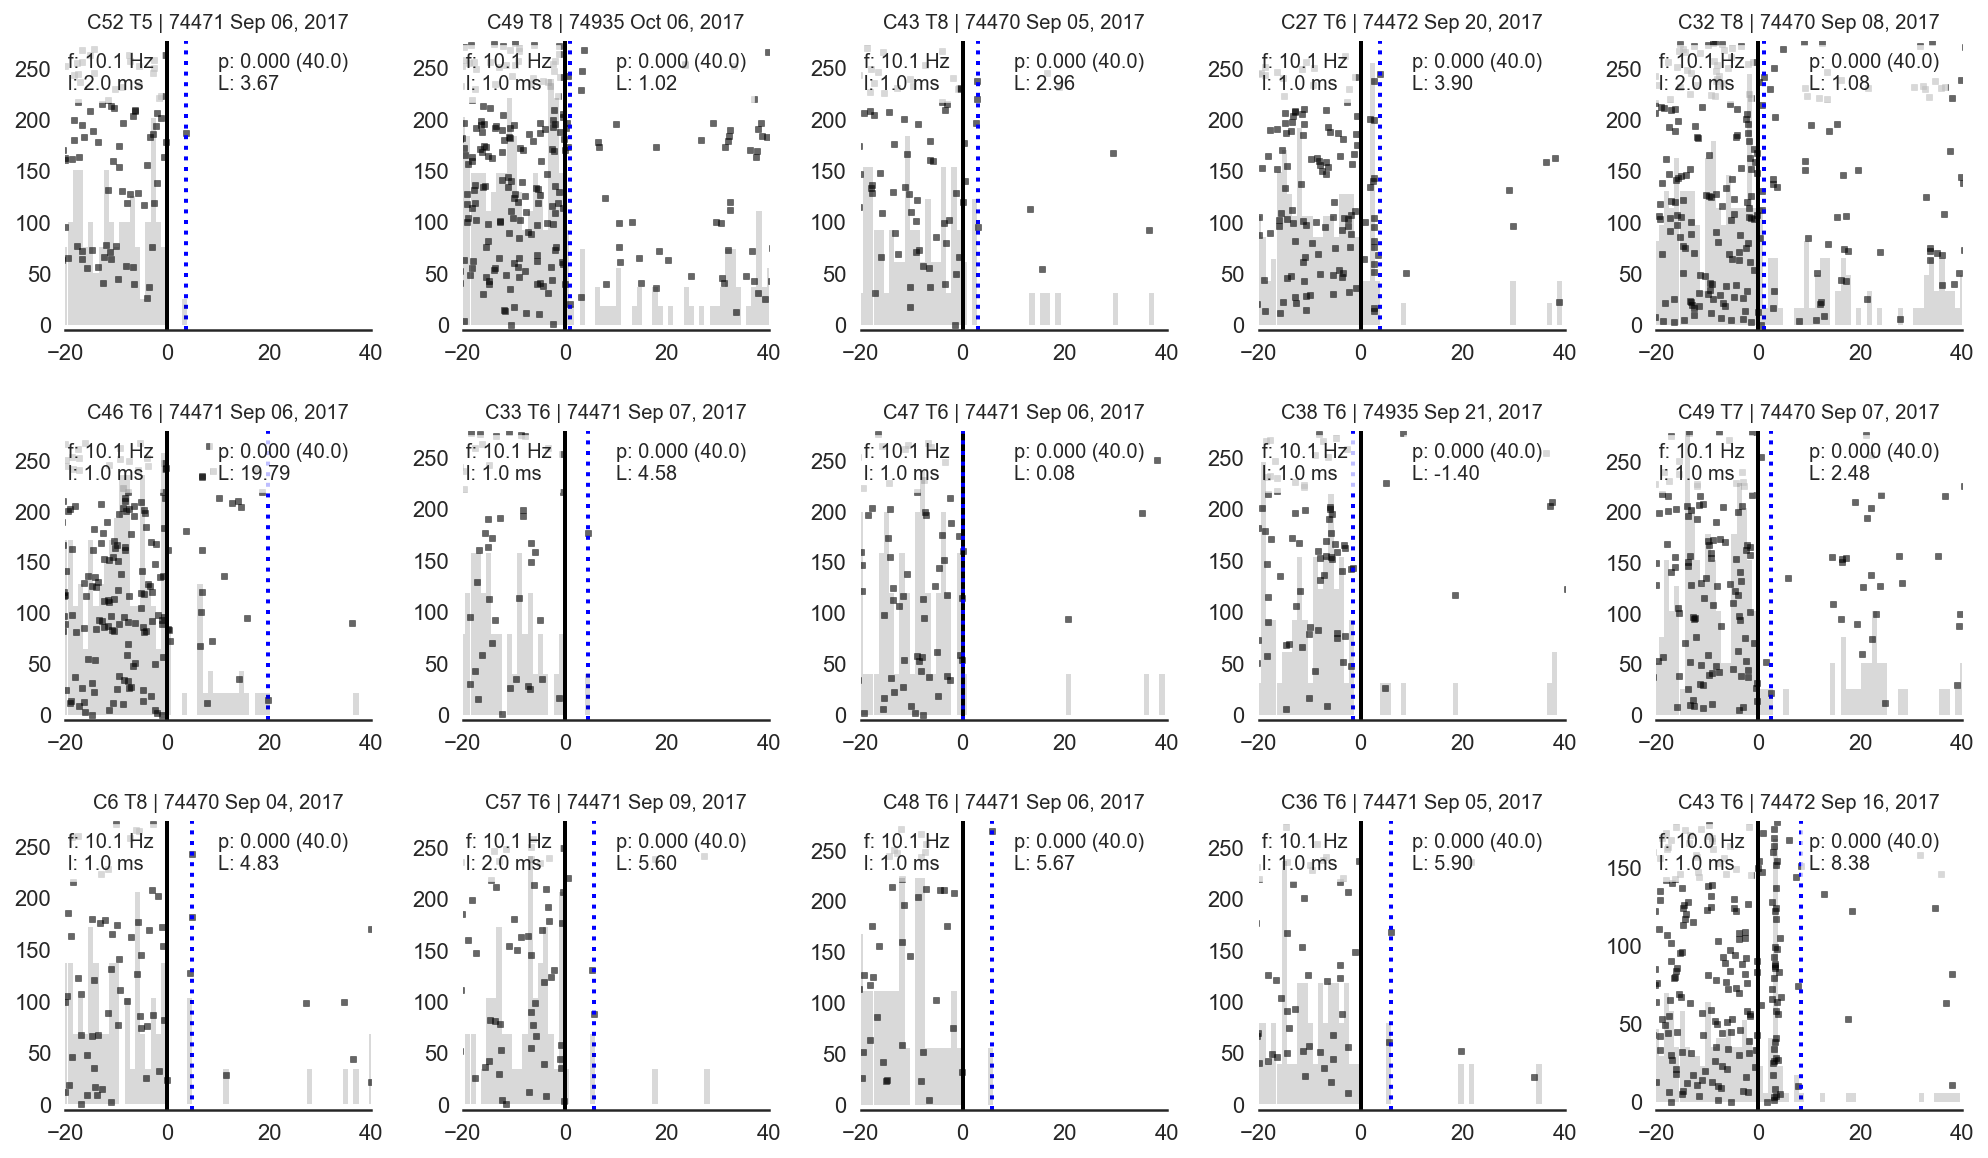

In [15]:
# Draw some example PSTHs
create_spike_plots_stimulus(inhibited_cells,15,0,True)

In [16]:
# Display a subset of the dataframe to check if everything went well
inhibited_cells[['animal_id','filename','tetrode_no','cluster_no','session_name','salt_i','salt_p']].head()

,animal_id,filename,tetrode_no,cluster_no,session_name,salt_i,salt_p
123,74471,N:/horsto/74471/06092017/KLUSTA/0.kwik,5,52,06092017s1,-0.110719,0.9
225,74935,L:/horsto/74935/06102017/KLUSTA/3.kwik,8,49,06102017s1,-0.0918875,0.878947
28,74470,N:/horsto/74470/05092017/KLUSTA/3.kwik,8,43,05092017s1,-0.0620212,0.826316
192,74472,N:/davidcr/74472/20092017_horstroom/KLUSTA/1.kwik,6,27,20092017s1,-0.0601268,0.742105
47,74470,N:/horsto/74470/08092017/KLUSTA/3.kwik,8,32,08092017s1,-0.0587127,0.826316


In [17]:
inhibited_cells.columns

Index(['cluster_no', 'tetrode_no', 'animal_id', 'session_ts', 'n_drive_user',
       'analysis_ts', 'filename', 'analysis_window', 'salt_window',
       'sample_rate', 'sample_rate_inp', 'ibi', 'stim_freq', 'stim_length',
       'counter_stimuli', 'excited', 'salt_p', 'salt_i', 'ex_latency_mean',
       'ex_latency_median', 'ex_latency_var', 'ex_latency_reliabil',
       'stats_p_inhib_10', 'stats_p_inhib_20', 'stats_p_inhib_30',
       'stats_p_inhib_40', 'inhibited', 'inhib_lowest_p',
       'inhib_lowest_p_interval', 'change_point_ms', 'no_sessions',
       'spiketimes_cluster', 'stimulus_timepoints', 'sum_1ms', 'bin_edges_1ms',
       'binnumber_1ms', 'isi_stats_contam_perc', 'session_name'],
      dtype='object')

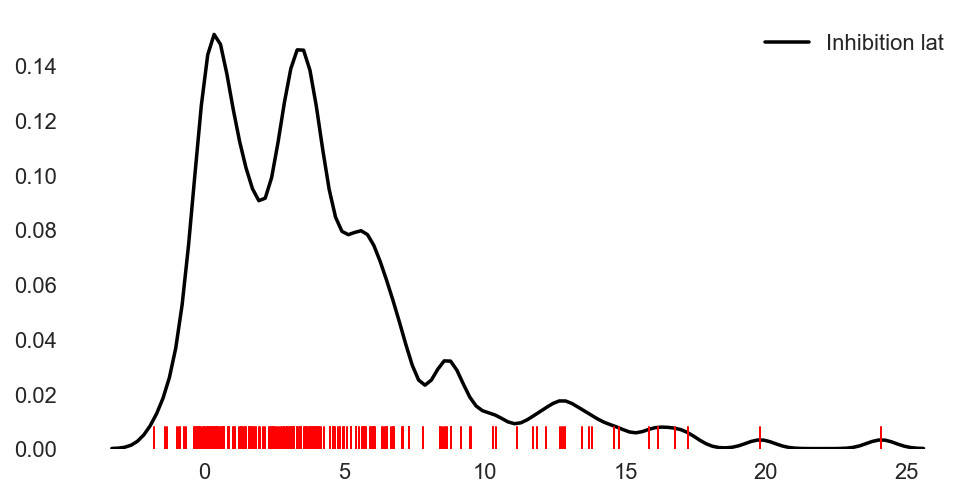

In [18]:
#excited_cells.ex_latency_median.hist(bins=20)
figure = plt.figure(figsize=(8,4))
ax = figure.add_subplot(111)
sns.kdeplot(inhibited_cells.change_point_ms.dropna(), bw=0.5, label="Inhibition lat",color='k',ax=ax)
sns.rugplot(inhibited_cells.change_point_ms.dropna(),color='r',ax=ax)
sns.despine(left=True,bottom=True)

### Save dataframe to pickle

In [19]:
inhibited_cells.to_pickle('dataframe_export/inhibited_cells.pkl')

In [20]:
len(inhibited_cells)

246

### To retrieve more data ... 

In [21]:
#psql = psql_neuroballs(excited_cells) # initialize retrieval
#psql.retrieve_data()

In [22]:
#data = psql.data()

In [23]:
# for example ... 
#draw_ratemaps(data,'masked_ratemap',15,0)